<a href="https://colab.research.google.com/github/ZnCl22222/MLFP/blob/main/Supervised_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 90803 MLFP-Data Cleaning and Question Definition
## Team 24: Huixuan Li (Connie), Sant Leelamanthep (Winn)
## Task 1: Supervised Learning

In [1]:
# Connect notebook with google drive
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [2]:
# Install PySpark
%%capture
!apt install libkrb5-dev
!wget https://downloads.apache.org/spark/spark-3.0.2/spark-3.0.2-bin-hadoop3.2.tgz
!tar xf spark-3.0.2-bin-hadoop3.2.tgz
# !pip install findspark
# !pip install sparkmagic
!pip install pyspark
!pip install pyspark --user

In [3]:
# Import packages
import pyspark
from pyspark.sql import SparkSession
from pyspark import SparkContext
from collections import OrderedDict
from pyspark.sql.functions import isnull, count, when, col, concat, concat_ws
from pyspark.sql.functions import abs, row_number, sum, lower, rank, split, desc, explode, collect_list
from pyspark.sql.window import Window
from pyspark.sql.functions import first
from pyspark.ml.feature import OneHotEncoder, StringIndexer
import pandas as pd
import pyspark.sql.functions as F
from pyspark.sql.functions import mean

Because of the large amount of data, we choose to use PySpark for data pre-processing first.

In [4]:
# Create a new Spark session 
spark = SparkSession.builder.appName('MLFP_Task1').getOrCreate()

# Read data

In [5]:
sc = spark.sparkContext
def read_data(datapath):
  """
  Read txt file and convert into DataFrame
  Input: txt file path
  Output: DataFrame
  """
  text_file = sc.textFile(datapath)
  header = text_file.first()
  data_rdd = text_file.filter(lambda line: line != header)
  split_rdd = data_rdd.map(lambda line: line.split("|"))
  data_row_rdd = split_rdd.map(lambda values: tuple(values))
  return data_row_rdd.toDF(header.split("|"))

In [6]:
df_test_result = read_data("/content/gdrive/My Drive/Dataset/Hba1cLong.txt")
df_test_result.show(5)

+----+------+-----+----------------+
|PtID|Method|HbA1c|HbA1cImputeDtMnC|
+----+------+-----+----------------+
|   1|   DCA|  6.8|          -1.959|
|   1|   DCA|  7.2|          10.888|
|   1|   DCA|  7.5|          24.166|
|   1|   DCA|  8.0|          38.274|
|   1|   DCA|  7.3|           67.12|
+----+------+-----+----------------+
only showing top 5 rows



In [7]:
df_diabete_hist = read_data("/content/gdrive/My Drive/Dataset/VisitsLong.txt")
df_diabete_hist.show(5)

+----+-----------+---------+----------+---------+------------+------------+----------------+----------+-------------------+----------------+-------------+----------------+---------------+------------+------------+-------------+-----------+----------------+-----------------+---------------+------------------+---------+--------+--------+--------+----------------------+-------+-------------------+------+------+------------+------------+--------+-------------------+---------+---+-------+------------------+---+--------+---+--------+-------+-------+------------+--------------+----------------+-----+--------+------------------+--------------+---------+----------------------+-------------------------+-----------------+--------------------+-----------------+----------------------+-------------------+------+------------+-----+------------------------+-----------+-----------+-----+----------------+-------------------------+---------------+---------------+---------------+---------------+----------

In [8]:
df_medical_cond = read_data("/content/gdrive/My Drive/Dataset/MedCondLong.txt")
df_medical_cond.show(5)

+----+----------------+----------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+---------------+--------------+
|PtID|MedCondDiagDtUnk|MedCondTrt|           MCLLTReal|               MCLLT|               MCHLT|              MCHLGT|          MCPrefTerm|               MCSOC|           MCLLTType|        MCGroup|medCondDiagAge|
+----+----------------+----------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+---------------+--------------+
|   1|                |          |        Hypertension|        Hypertension|Vascular hyperten...|Vascular hyperten...|        Hypertension|  Vascular disorders|Cardiovascular - ...| Cardiovascular|              |
|   1|               1|   Unknown|Preproliferative ...|Preproliferative ...|   Retinopathies NEC|Retina, choroid a...|Diabetic retinopathy|       Ey

In [9]:
df_medication = read_data("/content/gdrive/My Drive/Dataset/MedsLong.txt")
df_medication.show(5)

+----+----------+-----------+-----------+-----------+----------+--------------------+------+-----------+----------+
|PtID|Indication|MedStartCat|    MedDose|MedStartUnk|MedStopUnk|            DrugName| RXCUI|MedStartAge|MedStopAge|
+----+----------+-----------+-----------+-----------+----------+--------------------+------+-----------+----------+
|   1|          |           |100 mg/5 mL|          1|          |     Cromolyn Sodium|  3538|           |          |
|   1|          |           |      20 mg|          1|          |          Famotidine|  4278|           |          |
|   1|          |           |      25 mg|          1|          |Hydroxyzine Hydro...|154987|           |          |
|   1|          |           |       5 mg|           |         1|          Lisinopril| 29046|         41|          |
|   1|          |           |      20 MG|          1|          |          Omeprazole|  7646|           |          |
+----+----------+-----------+-----------+-----------+----------+--------

# Data Overview
Gain an initial insights of data

In [10]:
def data_overview(df, show_unique = 1):
    """
    Descriptive statistics of data
    Input: dataset
    Output: data summary
    """
    print('Rows number:', df.count())
    print('Columns number:', len(df.columns))
    print('Missing values:', df.select([count(when(isnull(c), c)).alias(c) for c in df.columns]).\
                        toPandas().sum().sum())
    print('Info:')
    df.printSchema()
    if show_unique:
      print('Unique values:')
      for c in df.columns:
          print('{:15}: '.format(c), df.select(c).distinct().count(), '\t', [row[c] for row in df.select(c).distinct().collect()[:10]])

In [11]:
data_overview(df_test_result, show_unique = 0)

Rows number: 134014
Columns number: 4
Missing values: 0
Info:
root
 |-- PtID: string (nullable = true)
 |-- Method: string (nullable = true)
 |-- HbA1c: string (nullable = true)
 |-- HbA1cImputeDtMnC: string (nullable = true)



In [12]:
data_overview(df_diabete_hist, show_unique = 0)

Rows number: 140461
Columns number: 98
Missing values: 0
Info:
root
 |-- PtID: string (nullable = true)
 |-- Visit: string (nullable = true)
 |-- ExamDtMnC: string (nullable = true)
 |-- ageConsent: string (nullable = true)
 |-- Pt_Gender: string (nullable = true)
 |-- Pt_PumpManuf: string (nullable = true)
 |-- Pt_PumpModel: string (nullable = true)
 |-- Pt_CGMUseNumDays: string (nullable = true)
 |-- Pt_InsPriv: string (nullable = true)
 |-- Pt_InsSingleService: string (nullable = true)
 |-- Pt_InsNoCoverage: string (nullable = true)
 |-- Pt_InsUnknown: string (nullable = true)
 |-- Pt_MaritalStatus: string (nullable = true)
 |-- Pt_ImmBioFamT1D: string (nullable = true)
 |-- Pt_FatherT1D: string (nullable = true)
 |-- Pt_MotherT1D: string (nullable = true)
 |-- Pt_SiblingT1D: string (nullable = true)
 |-- Pt_ChildT1D: string (nullable = true)
 |-- Pt_GrandchildT1D: string (nullable = true)
 |-- Pt_GrandparentT1D: string (nullable = true)
 |-- Pt_ExtBioFamT1D: string (nullable = true

In [13]:
data_overview(df_medical_cond, show_unique = 0)

Rows number: 96782
Columns number: 12
Missing values: 0
Info:
root
 |-- PtID: string (nullable = true)
 |-- MedCondDiagDtUnk: string (nullable = true)
 |-- MedCondTrt: string (nullable = true)
 |-- MCLLTReal: string (nullable = true)
 |-- MCLLT: string (nullable = true)
 |-- MCHLT: string (nullable = true)
 |-- MCHLGT: string (nullable = true)
 |-- MCPrefTerm: string (nullable = true)
 |-- MCSOC: string (nullable = true)
 |-- MCLLTType: string (nullable = true)
 |-- MCGroup: string (nullable = true)
 |-- medCondDiagAge: string (nullable = true)



In [14]:
data_overview(df_medication, show_unique = 0)

Rows number: 131519
Columns number: 10
Missing values: 0
Info:
root
 |-- PtID: string (nullable = true)
 |-- Indication: string (nullable = true)
 |-- MedStartCat: string (nullable = true)
 |-- MedDose: string (nullable = true)
 |-- MedStartUnk: string (nullable = true)
 |-- MedStopUnk: string (nullable = true)
 |-- DrugName: string (nullable = true)
 |-- RXCUI: string (nullable = true)
 |-- MedStartAge: string (nullable = true)
 |-- MedStopAge: string (nullable = true)



# Data Preprocess
## Change format
We found that the initial read-in data formats are all strings, and we will manually adjust the data formats.

In [15]:
df_test_result_rf = df_test_result.select(
    col("PtID").cast("int"),
    col("Method").cast("string"),
    col("HbA1c").cast("float"),
    col("HbA1cImputeDtMnC").cast("float")
)
data_overview(df_test_result_rf)

Rows number: 134014
Columns number: 4
Missing values: 17399
Info:
root
 |-- PtID: integer (nullable = true)
 |-- Method: string (nullable = true)
 |-- HbA1c: float (nullable = true)
 |-- HbA1cImputeDtMnC: float (nullable = true)

Unique values:
PtID           :  33541 	 [10206, 102793, 103011, 10362, 10623, 10817, 1088, 11033, 11141, 11317]
Method         :  6 	 ['DCA', 'Unknown', 'Other POC', '', 'Lab', 'Afinion']
HbA1c          :  139 	 [9.100000381469727, 9.399999618530273, 6.900000095367432, 13.199999809265137, 11.300000190734863, 15.300000190734863, 15.100000381469727, 16.399999618530273, 9.0, 13.699999809265137]
HbA1cImputeDtMnC:  3037 	 [4.613999843597412, 35.15399932861328, 16.332000732421875, 53.31100082397461, 3.319999933242798, 81.99199676513672, 9.859000205993652, 68.51499938964844, -47.667999267578125, 6.704999923706055]


In [16]:
df_diabete_hist_rf = df_diabete_hist.select(
    col("PtID").cast("int"), col("Visit").cast("string"), col("ExamDtMnC").cast("float"), col("Pt_Gender").cast("string"),
    col("Pt_PumpManuf").cast("int"), col("Pt_PumpModel").cast("string"), col("Pt_CGMUseNumDays").cast("float"),
    col("Pt_InsPriv").cast("int"), col("Pt_InsSingleService").cast("int"), col("Pt_InsNoCoverage").cast("int"), col("Pt_InsUnknown").cast("int"),
    col("Pt_MaritalStatus").cast("string"), col("Pt_ImmBioFamT1D").cast("string"), col("Pt_FatherT1D").cast("int"), col("Pt_MotherT1D").cast("int"),
    col("Pt_SiblingT1D").cast("int"), col("Pt_ChildT1D").cast("int"), col("Pt_GrandchildT1D").cast("int"), col("Pt_GrandparentT1D").cast("int"),
    col("Pt_ExtBioFamT1D").cast("string"), col("Pt_raceEthNew").cast("string"), col("HeightUnk").cast("int"), col("BldPrSys").cast("float"),
    col("BldPrDia").cast("float"), col("BldPrUnk").cast("int"), col("SMBGperDayPtMeterCombo").cast("float"), col("CGMUsed").cast("string"),
    col("AlbuminuriaStatus").cast("string"), col("ACEARB").cast("string"), col("InsUnk").cast("int"), col("InsNotTaking").cast("int"),
    col("WeightKg").cast("float"), col("HeightCm").cast("float"), col("LipidsFastingStatus").cast("string"), col("DirectLDL").cast("int"),
    col("age").cast("int"), col("diabDur").cast("int"), col("TotalDailyInsPerKg").cast("float"), col("LDL").cast("float"),
    col("LDLUnits").cast("string"), col("HDL").cast("float"), col("HDLUnits").cast("string"), col("TotChol").cast("float"),
    col("Triglyc").cast("float"), col("TriglycUnits").cast("string"), col("CollectionType").cast("string"), col("BloodTstNotAvail").cast("int"),
    col("BUN").cast("float"), col("BUNUnits").cast("string"), col("AlbCreatRat_mggNew").cast("float"), col("PregInPastYear").cast("string"),
    col("InjMethod").cast("string"), col("UnitsInsBasalOrLongAct").cast("float"), col("UnitsInsBasalOrLongActUnk").cast("int"), col("BGTestAvgNumMeter").cast("float"),
    col("BGTestMetDatNotAvail").cast("int"), col("BGTestAvgNumPtRep").cast("float"), col("BGTestPtRepDatNotAvail").cast("int"), col("CGMUsedDevRschStudy").cast("string"),
    col("NoExam").cast("int"), col("GFRIsBelow60").cast("string"), col("TSH").cast("float"), col("Pt_InsulinDeliveryMethod").cast("string"),
    col("Pt_CGMManuf").cast("string"), col("Pt_CGMModel").cast("string"), col("HbA1c").cast("float"), col("AutonomicNeuroCl").cast("int"),
    col("SMBGperDayPtMeterComboCat").cast("string"), col("InsulinUsedNew1").cast("string"), col("InsulinUsedNew2").cast("string"), col("InsulinUsedNew3").cast("string"),
    col("InsulinUsedNew4").cast("string"), col("InsulinUsedNew5").cast("string"), col("InsulinUsedNew6").cast("string"), col("Pt_InsGov").cast("int"),
    col("PregAtVisit").cast("string"), col("NumPumpBolusOrShortAct").cast("int"), col("isletCellTrans").cast("string"), col("pancreasTrans").cast("string"),
    col("WeightUnk").cast("int"), col("HbA1cImputeDtMnC").cast("float"), col("Pt_SHFlg").cast("int"), col("Pt_DKAFlg").cast("int"),
    col("bmi").cast("float"), col("bmiPerc").cast("float"), col("bmiZscore").cast("float"), col("Pt_SmokeCurr").cast("string"),
    col("Pt_EduLevel").cast("string"), col("Pt_AnnualInc").cast("string"), col("NumPumpBolusOrShortActUnk").cast("int"), col("GFR").cast("float"),
    col("diagAgeCombo").cast("int"), col("Pt_A1cGoal").cast("string"), col("Pt_A1cGoalLev").cast("float"), col("Pt_A1cGoalLevelYr5").cast("string"),
    col("Pt_A1cGoalLevelDsYr5").cast("string"), col("SiteID").cast("int")
)

data_overview(df_diabete_hist_rf, show_unique = 0)

Rows number: 140461
Columns number: 97
Missing values: 3948317
Info:
root
 |-- PtID: integer (nullable = true)
 |-- Visit: string (nullable = true)
 |-- ExamDtMnC: float (nullable = true)
 |-- Pt_Gender: string (nullable = true)
 |-- Pt_PumpManuf: integer (nullable = true)
 |-- Pt_PumpModel: string (nullable = true)
 |-- Pt_CGMUseNumDays: float (nullable = true)
 |-- Pt_InsPriv: integer (nullable = true)
 |-- Pt_InsSingleService: integer (nullable = true)
 |-- Pt_InsNoCoverage: integer (nullable = true)
 |-- Pt_InsUnknown: integer (nullable = true)
 |-- Pt_MaritalStatus: string (nullable = true)
 |-- Pt_ImmBioFamT1D: string (nullable = true)
 |-- Pt_FatherT1D: integer (nullable = true)
 |-- Pt_MotherT1D: integer (nullable = true)
 |-- Pt_SiblingT1D: integer (nullable = true)
 |-- Pt_ChildT1D: integer (nullable = true)
 |-- Pt_GrandchildT1D: integer (nullable = true)
 |-- Pt_GrandparentT1D: integer (nullable = true)
 |-- Pt_ExtBioFamT1D: string (nullable = true)
 |-- Pt_raceEthNew: stri

In [17]:
df_medical_cond_rf = df_medical_cond.select(
    col("PtID").cast("int"), col("MedCondDiagDtUnk").cast("int"), col("MedCondTrt").cast("string"), col("MCLLTReal").cast("string"),
    col("MCLLT").cast("string"), col("MCHLT").cast("string"), col("MCHLGT").cast("string"), col("MCPrefTerm").cast("string"),
    col("MCSOC").cast("string"), col("MCLLTType").cast("string"), col("MCGroup").cast("string"), col("medCondDiagAge").cast("int"),
)
data_overview(df_medical_cond_rf)

Rows number: 96782
Columns number: 12
Missing values: 126633
Info:
root
 |-- PtID: integer (nullable = true)
 |-- MedCondDiagDtUnk: integer (nullable = true)
 |-- MedCondTrt: string (nullable = true)
 |-- MCLLTReal: string (nullable = true)
 |-- MCLLT: string (nullable = true)
 |-- MCHLT: string (nullable = true)
 |-- MCHLGT: string (nullable = true)
 |-- MCPrefTerm: string (nullable = true)
 |-- MCSOC: string (nullable = true)
 |-- MCLLTType: string (nullable = true)
 |-- MCGroup: string (nullable = true)
 |-- medCondDiagAge: integer (nullable = true)

Unique values:
PtID           :  24750 	 [10206, 102793, 10623, 11033, 11141, 11458, 11748, 11858, 12027, 12046]
MedCondDiagDtUnk:  2 	 [None, 1]
MedCondTrt     :  8 	 ['None', 'Unknown', 'Other', 'Medication', 'Medication and Surgery', 'Surgery', '', 'Dietary Management']
MCLLTReal      :  1567 	 ['Enlarged thyroid', 'Drug abuse', 'Secondary cataract', 'Nightmares', 'Keratopathy NOS', 'Charcot arthropathy', 'Arteriovenous fistula', 'Im

In [18]:
df_medication_rf = df_medication.select(
    col("PtID").cast("int"), col("Indication").cast("string"), col("MedStartCat").cast("string"), col("MedDose").cast("string"),
    col("MedStartUnk").cast("int"), col("MedStopUnk").cast("int"), col("DrugName").cast("string"), col("RXCUI").cast("string"),
    col("MedStartAge").cast("int"), col("MedStopAge").cast("int")
)
data_overview(df_medication_rf)

Rows number: 131519
Columns number: 10
Missing values: 393287
Info:
root
 |-- PtID: integer (nullable = true)
 |-- Indication: string (nullable = true)
 |-- MedStartCat: string (nullable = true)
 |-- MedDose: string (nullable = true)
 |-- MedStartUnk: integer (nullable = true)
 |-- MedStopUnk: integer (nullable = true)
 |-- DrugName: string (nullable = true)
 |-- RXCUI: string (nullable = true)
 |-- MedStartAge: integer (nullable = true)
 |-- MedStopAge: integer (nullable = true)

Unique values:
PtID           :  24582 	 [10206, 102793, 10362, 10623, 10817, 1088, 11033, 11141, 11317, 11458]
Indication     :  4 	 ['Medical Condition', 'Unknown', 'Prevention', '']
MedStartCat    :  6 	 ['1 - <5 years', 'Unknown', '>=10 years', '5 - <10 years', '', '< 1 year']
MedDose        :  11226 	 ['1% external swab', '300mg', '1.25mg QW x 12 weeks', '500 mg every other night at bedtime', '20mg q d', '500 mg every 12 hours', '108 mcg', '30 mcg TID', '10 mg daily at HS', '1mg qd']
MedStartUnk    :  2 

# Data Cleaning

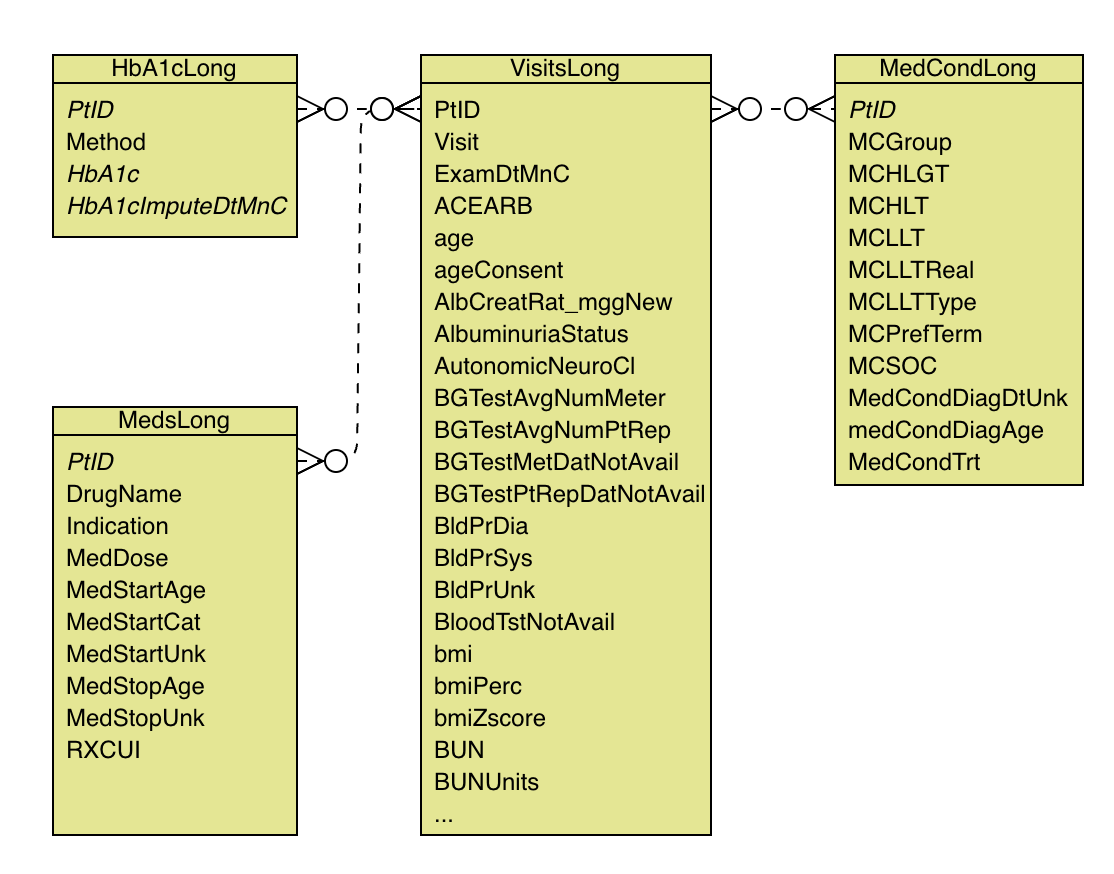

Our database consists of four tables:


*   Main table: VisitsLong (df_diabete_hist_rf): One record per subject per visit
*   HbA1cLong (df_test_result_rf): One record per HbA1c measurement
*   MedCondLong (df_medical_cond_rf): One record per medical condition recorded
*   MedsLong (df_medication_rf): One record per medication recorded

Since the same participant may visit multiple times, measure hba1c multiple times, have multiple medical histories and take multiple medications. All four forms are linked in a many-to-many format. 

**For HbA1cLong:**

The method of measuring HbA1c is the only valuable feature among the four variables (as other 3 variables already exist in main table). To handle this, we first removed all records where the method is null and kept only those with a valid method. However, we noticed that the same HbA1c and HbA1cImputeDtMnC values could correspond to different methods in the same participant. Therefore, we chose to select the first method in the data to ensure consistency. This resulted in a table that includes Ptid, HbA1c, and HbA1cImputeDtMnC corresponding to one method.

Moreover, we found cases where the same patient has null values for HbA1cImputeDtMnC in this table, but not in the main table. This led to unmatched data, which we addressed by generating a sub-table using the method mentioned above. This allowed us to obtain a table that includes Ptid and HbA1c corresponding to the unique method and join the data that did not match in the first join. By doing so, we can ensure that we have a complete and accurate dataset for our analysis.

**For MedCondLong & MedsLong:**

Since each participant at a certain age may have different medical conditions and medication records, these records can be considered individual features of the participant. To incorporate these features into our analysis, we need to transform the original long table into a wide table that links each participant's medical records and medication records to the main table by the participant ID and corresponding age. By doing so, we can analyze the data at the individual level and better understand the relationship between a participant's medical condition, medication use, and risk of hypoglycemic events.

Due to the large number of medical conditions and medications involved, breaking down the information into individual features would result in very large sparse matrices, which we do not have enough data to support. Therefore, we chose to retain only the McGroup and MedCondTrt variables to show the medical conditions presented and the treatments received by the participants. After discussion with prof GS over zoom, we are subsetting medications for 30 most frequent medications instead of having a sparse matrix. Some medications potentially contribute to hypoglycemic events. However, we will include this in the next iteration. Additionally, in future iterations, we will perform dimensionality reduction by grouping drugs into appropriate classes e.g. ibuprofen, acetaminophen, naproxen will all be encoded as 'NSAIDs'.

By doing so, we can still explore the relationship between these variables and the presence of adverse events while avoiding the issues associated with sparse matrices. This approach allows us to focus on the most important features without sacrificing the quality of our analysis.

In [19]:
# Missing data check
def data_missing(df):
  """
    Print missing data count and percentage
    Input: dataset
    Output: missing data summary
  """
  # Count the number of null values in each column
  total_rows = df.count()
  null_counts = [(c, df.filter(df[c].isNull()).count()) for c in df.columns]
  
  # Print the null value count for each column
  for c, count in null_counts:
    percentage = round((count/total_rows)*100, 2)
    print(f"{c}: {count} ({percentage}%)")

### HbA1cLong: One record per HbA1c measurement

In [20]:
# Check missing data
df_test_result_wo_na = df_test_result_rf.select([when(col(c) == '', None).otherwise(col(c)).alias(c) for c in df_test_result_rf.columns]).dropDuplicates()
data_missing(df_test_result_wo_na)

PtID: 0 (0.0%)
Method: 1414 (1.06%)
HbA1c: 0 (0.0%)
HbA1cImputeDtMnC: 16746 (12.57%)


In [21]:
# Drop row with empty method
df_test_result_wo_na = df_test_result_wo_na.dropna(subset=['Method'])
# Select the first method in the data to ensure consistency
df_test_result_wo_na = df_test_result_wo_na.groupBy('PtID', 'HbA1c', 'HbA1cImputeDtMnC').agg(first('Method').alias('Method'))
# Create subset to deal with special cases
df_test_result_wo_na_subset = df_test_result_wo_na.groupBy('PtID', 'HbA1c').agg(first('Method').alias('Method'))
data_overview(df_test_result_wo_na, show_unique=0)

Rows number: 131801
Columns number: 4
Missing values: 16340
Info:
root
 |-- PtID: integer (nullable = true)
 |-- HbA1c: float (nullable = true)
 |-- HbA1cImputeDtMnC: float (nullable = true)
 |-- Method: string (nullable = true)



### VisitsLong: One record per subject per visit

Our main dataset, VisitsLong, contains the target variable Pt_SHFlg, which indicates whether a patient has experienced severe hypoglycemia events in the past 12 months. To build a model that predicts future severe hypoglycemia events, we need to select data where Visit = Enrollment1 as the feature variable and treat the Pt_SHFlg data for the same patient with Visit = Year 1 (1 year after enrollment) as the target variable. This way, we can use the feature variable to predict the target variable and determine whether a patient is at risk of experiencing severe hypoglycemia events in the future.

In [22]:
# Drop data with null in target variable Pt_SHFlg and remain records with 'Enrollment1' and 'Year 1'
df_diabete_hist_full_y = df_diabete_hist_rf.dropna(subset = ['Pt_SHFlg']).filter(df_diabete_hist_rf.Visit.isin(['Year 1', 'Enrollment1']))
# Select patient with both 'Enrollment1' and 'Year 1' record
concatenated_visits = df_diabete_hist_full_y.groupBy('PtID').agg(concat_ws(',', F.collect_list('Visit')).alias('ConcatenatedVisits'))
split_visits = concatenated_visits.withColumn('VisitList', split('ConcatenatedVisits', ','))
ptids = split_visits.filter(F.size('VisitList') > 1).select('PtID').rdd.flatMap(lambda x: x).collect()

df_diabete_hist_full_y = df_diabete_hist_full_y.filter(F.col('PtID').isin(ptids))

In [23]:
# Filter for records with Visit = Enrollment1
enrollment1 = df_diabete_hist_full_y.filter(col("Visit") == "Enrollment1").drop('Pt_SHFlg')
# Join with Year 1 target variable on PtID
df_diabete_hist = enrollment1.join(df_diabete_hist_full_y.filter(col("Visit") == "Year 1").select('PtID', 'Pt_SHFlg'), on=["PtID"], how="inner")

In [24]:
# Check missing data (Would run around 17 mins)
df_diabete_hist_wo_na = df_diabete_hist.select([when(col(c) == '', None).otherwise(col(c)).alias(c) for c in df_diabete_hist_rf.columns]).dropDuplicates()
data_missing(df_diabete_hist_wo_na)

PtID: 0 (0.0%)
Visit: 0 (0.0%)
ExamDtMnC: 0 (0.0%)
Pt_Gender: 0 (0.0%)
Pt_PumpManuf: 13002 (100.0%)
Pt_PumpModel: 6295 (48.42%)
Pt_CGMUseNumDays: 11894 (91.48%)
Pt_InsPriv: 987 (7.59%)
Pt_InsSingleService: 987 (7.59%)
Pt_InsNoCoverage: 987 (7.59%)
Pt_InsUnknown: 13002 (100.0%)
Pt_MaritalStatus: 6084 (46.79%)
Pt_ImmBioFamT1D: 0 (0.0%)
Pt_FatherT1D: 12319 (94.75%)
Pt_MotherT1D: 12652 (97.31%)
Pt_SiblingT1D: 11901 (91.53%)
Pt_ChildT1D: 12844 (98.78%)
Pt_GrandchildT1D: 12977 (99.81%)
Pt_GrandparentT1D: 11998 (92.28%)
Pt_ExtBioFamT1D: 0 (0.0%)
Pt_raceEthNew: 0 (0.0%)
HeightUnk: 11715 (90.1%)
BldPrSys: 485 (3.73%)
BldPrDia: 485 (3.73%)
BldPrUnk: 12517 (96.27%)
SMBGperDayPtMeterCombo: 75 (0.58%)
CGMUsed: 0 (0.0%)
AlbuminuriaStatus: 0 (0.0%)
ACEARB: 0 (0.0%)
InsUnk: 12631 (97.15%)
InsNotTaking: 12994 (99.94%)
WeightKg: 1292 (9.94%)
HeightCm: 1287 (9.9%)
LipidsFastingStatus: 3333 (25.63%)
DirectLDL: 12200 (93.83%)
age: 0 (0.0%)
diabDur: 0 (0.0%)
TotalDailyInsPerKg: 1769 (13.61%)
LDL: 4280 (32.9

For missing data preprocess, we mainly follow several rules:
1. Drop variables with missing data percentage > 30%
2. For binary variables: treat null as 0 (For variables like Pt_FatherT1D, which indicate whether the father has type 1 diabetes, we chose to simplify the variable by treating the value of 1 as indicating that the father has diabetes, and treating all other values as indicating that the father does not have diabetes. ）
3. For variables with missing data percentage < 30%, we impute mean for continuous variables and mode for discrete variables

In [25]:
# Deal with if biological family have type 1 diabetes
df_diabete_hist_tmp1 = df_diabete_hist_wo_na.fillna({'Pt_FatherT1D': 0, 'Pt_MotherT1D': 0, 'Pt_SiblingT1D': 0, 'Pt_ChildT1D': 0, 'Pt_GrandchildT1D': 0, 'Pt_GrandparentT1D': 0})
df_diabete_hist_tmp1 = df_diabete_hist_tmp1.withColumn("Pt_ImmBioFamT1D", when((df_diabete_hist_tmp1["Pt_ImmBioFamT1D"] == "Yes") |(df_diabete_hist_tmp1["Pt_ImmBioFamT1D"] == '1.Yes'), 1).otherwise(0))
df_diabete_hist_tmp1 = df_diabete_hist_tmp1.withColumn("Pt_ExtBioFamT1D", when((df_diabete_hist_tmp1["Pt_ExtBioFamT1D"] == "Yes") |(df_diabete_hist_tmp1["Pt_ExtBioFamT1D"] == '1.Yes'), 1).otherwise(0))

# Deal with insurance features
df_diabete_hist_tmp2 = df_diabete_hist_tmp1.fillna({'Pt_InsPriv': 0, 'Pt_InsSingleService': 0, 'Pt_InsNoCoverage': 0, 'Pt_InsGov': 0})
df_diabete_hist_tmp2 = df_diabete_hist_tmp2.drop('Pt_InsUnknown')

# Deal with patient goal
df_diabete_hist_tmp3 = df_diabete_hist_tmp2.drop('Pt_A1cGoal', 'Pt_A1cGoalLev', 'Pt_A1cGoalLevelYr5', 'Pt_A1cGoalLevelDsYr5')

# Deal with health related indicator
mean_BldPrSys = df_diabete_hist_tmp3.agg(mean('BldPrSys')).collect()[0][0]
mean_BldPrDia = df_diabete_hist_tmp3.agg(mean('BldPrDia')).collect()[0][0]
mean_WeightKg = df_diabete_hist_tmp3.agg(mean('WeightKg')).collect()[0][0]
mean_HeightCm = df_diabete_hist_tmp3.agg(mean('HeightCm')).collect()[0][0]
mean_HbA1c = df_diabete_hist_tmp3.agg(mean('HbA1c')).collect()[0][0]
mean_HbA1cImputeDtMnC = df_diabete_hist_tmp3.agg(mean('HbA1cImputeDtMnC')).collect()[0][0]
mean_bmi = df_diabete_hist_tmp3.agg(mean('bmi')).collect()[0][0]
mean_SMBGperDayPtMeterCombo = df_diabete_hist_tmp3.agg(mean('SMBGperDayPtMeterCombo')).collect()[0][0]
mean_BGTestAvgNumPtRep = df_diabete_hist_tmp3.agg(mean('BGTestAvgNumPtRep')).collect()[0][0]
mean_TotalDailyInsPerKg = df_diabete_hist_tmp3.agg(mean('TotalDailyInsPerKg')).collect()[0][0]
mode_SMBGperDayPtMeterComboCat = df_diabete_hist_tmp3.select('SMBGperDayPtMeterComboCat').groupBy('SMBGperDayPtMeterComboCat').count().orderBy('count', ascending=False).first()[0]
df_diabete_hist_tmp4 = df_diabete_hist_tmp3.fillna({'BldPrSys': mean_BldPrSys, 'BldPrDia': mean_BldPrDia,
                                                    'SMBGperDayPtMeterCombo': mean_SMBGperDayPtMeterCombo, 'SMBGperDayPtMeterComboCat': mode_SMBGperDayPtMeterComboCat,
                                                    'AlbuminuriaStatus': 'Unknown', 'WeightKg': mean_WeightKg, 'HeightCm': mean_HeightCm, 'DirectLDL': 0,
                                                    'bmi': mean_bmi, 'Pt_DKAFlg':0, 'HbA1c': mean_HbA1c, 'HbA1cImputeDtMnC': mean_HbA1cImputeDtMnC, 
                                                    'BGTestAvgNumPtRep': mean_BGTestAvgNumPtRep, 'TotalDailyInsPerKg': mean_TotalDailyInsPerKg})
df_diabete_hist_tmp4 = df_diabete_hist_tmp4.withColumn("CGMUsed", when(df_diabete_hist_tmp4["CGMUsed"] == "Yes", 1).otherwise(0))
df_diabete_hist_tmp4 = df_diabete_hist_tmp4.withColumn("ACEARB", when(df_diabete_hist_tmp4["ACEARB"] == "Yes", 1).otherwise(0))
df_diabete_hist_tmp4 = df_diabete_hist_tmp4.withColumn("GFRIsBelow60", when(df_diabete_hist_tmp4["GFRIsBelow60"] == "Yes", 1).otherwise(0))
df_diabete_hist_tmp4 = df_diabete_hist_tmp4.withColumn("isletCellTrans", when(df_diabete_hist_tmp4["isletCellTrans"] == "Yes", 1).otherwise(0))
df_diabete_hist_tmp4 = df_diabete_hist_tmp4.withColumn("pancreasTrans", when(df_diabete_hist_tmp4["pancreasTrans"] == "Yes", 1).otherwise(0))
df_diabete_hist_tmp4 = df_diabete_hist_tmp4.withColumn("LipidsFastingStatus", when(df_diabete_hist_tmp4["LipidsFastingStatus"] == "Fasting", 1).otherwise(0))
df_diabete_hist_tmp4 = df_diabete_hist_tmp4.drop('LDL', 'LDLUnits', 'HDL', 'HDLUnits', 'TotChol', 'Triglyc', 'TriglycUnits', 'BUN', 'BUNUnits', 
                                                 'BGTestAvgNumMeter', 'UnitsInsBasalOrLongAct', 'GFR', 'AlbCreatRat_mggNew', 'CollectionType', 'TSH',
                                                 'NumPumpBolusOrShortAct', 'InjMethod', 'NoExam', 'CGMUsedDevRschStudy', 'HeightUnk', 
                                                 'BldPrUnk', 'BloodTstNotAvail', 'UnitsInsBasalOrLongActUnk', 'BGTestMetDatNotAvail', 'BGTestPtRepDatNotAvail', 
                                                 'WeightUnk', 'bmiPerc', 'bmiZscore', 'NumPumpBolusOrShortActUnk')

In [26]:
# Deal with insulin related features
df_diabete_hist_tmp5 = df_diabete_hist_tmp4.withColumn("InsNotTaking", when(df_diabete_hist_tmp4["InsNotTaking"] == 1, 1).otherwise(0))
df_diabete_hist_tmp5 = df_diabete_hist_tmp5.withColumn("InsUnk", when(df_diabete_hist_tmp5["InsUnk"] == 1, 1).otherwise(0))
df_diabete_hist_tmp5 = df_diabete_hist_tmp5.fillna({'Pt_InsulinDeliveryMethod': 'Unknown', 'AutonomicNeuroCl':0})
# For this variables, we combined InsulinUsedNew1-InsulinUsedNew6 to a new variable InsulinUsedNew and would perform one-hot encoding latter
df_diabete_hist_tmp5 = df_diabete_hist_tmp5.select("*", concat_ws(",", "InsulinUsedNew1", "InsulinUsedNew2", "InsulinUsedNew3",
                                      "InsulinUsedNew4", "InsulinUsedNew5", "InsulinUsedNew6").alias("InsulinUsed"))
df_diabete_hist_tmp5 = df_diabete_hist_tmp5.drop("InsulinUsedNew1", "InsulinUsedNew2", "InsulinUsedNew3",
                                      "InsulinUsedNew4", "InsulinUsedNew5", "InsulinUsedNew6")

# Deal with patient characristics
df_diabete_hist_tmp6 = df_diabete_hist_tmp5.withColumn("PregInPastYear", when(df_diabete_hist_tmp5["PregInPastYear"] == "Yes", 1).otherwise(0))
df_diabete_hist_tmp6 = df_diabete_hist_tmp6.withColumn("PregAtVisit", when(df_diabete_hist_tmp6["PregAtVisit"] == "Yes", 1).otherwise(0))
df_diabete_hist_tmp6 = df_diabete_hist_tmp6.withColumn("Pt_SmokeCurr", when(df_diabete_hist_tmp6["Pt_SmokeCurr"] == "Yes", 1).otherwise(0))
mode_EduLevel = df_diabete_hist_tmp6.select('Pt_EduLevel').groupBy('Pt_EduLevel').count().orderBy('count', ascending=False).first()[0]
mode_Pt_AnnualInc = df_diabete_hist_tmp6.filter(col('Pt_AnnualInc').isNotNull()).select('Pt_AnnualInc').groupBy('Pt_AnnualInc').count().orderBy('count', ascending=False).first()[0]
df_diabete_hist_tmp6 = df_diabete_hist_tmp6.fillna({'Pt_EduLevel': mode_EduLevel, 'Pt_AnnualInc': mode_Pt_AnnualInc})
df_diabete_hist_tmp6 = df_diabete_hist_tmp6.drop('Pt_MaritalStatus', 'Visit', 'SiteID')
# Transfer to ordinal variables
df_diabete_hist_tmp6 = df_diabete_hist_tmp6.withColumn("Pt_EduLevel", when(df_diabete_hist_tmp6["Pt_EduLevel"] == '1. Less than high school', 1)
                                 .when(df_diabete_hist_tmp6["Pt_EduLevel"] == '2. Highschool diploma\\GED', 2)
                                 .when(df_diabete_hist_tmp6["Pt_EduLevel"] == '3. Associate degree', 3)
                                 .when(df_diabete_hist_tmp6["Pt_EduLevel"] == '4. Bachelor degree', 4)
                                 .when(df_diabete_hist_tmp6["Pt_EduLevel"] == '5. Master degree', 5)
                                 .when(df_diabete_hist_tmp6["Pt_EduLevel"] == '6. Professional/Doctorate Degree', 6)
                                 .otherwise(0))
df_diabete_hist_tmp6 = df_diabete_hist_tmp6.withColumn('Pt_AnnualInc', when(df_diabete_hist_tmp6['Pt_AnnualInc'] == 'Less than $25,000', 1)
                                 .when(df_diabete_hist_tmp6['Pt_AnnualInc'] == '$25,000 - $35,000', 2)
                                 .when(df_diabete_hist_tmp6['Pt_AnnualInc'] == '$35,000 - less than $50,000', 3)
                                 .when(df_diabete_hist_tmp6['Pt_AnnualInc'] == '$50,000 - less than $75,000', 4)
                                 .when(df_diabete_hist_tmp6['Pt_AnnualInc'] == '$75,000 - less than $100,000', 5)
                                 .when(df_diabete_hist_tmp6['Pt_AnnualInc'] == '$100,000 - less than $200,000', 6)
                                 .when(df_diabete_hist_tmp6['Pt_AnnualInc'] == '$200,000 or more', 7)
                                 .otherwise(0))

df_diabete_hist_clean = df_diabete_hist_tmp6.dropna(subset=["Pt_Gender"])
df_diabete_hist_clean = df_diabete_hist_clean.dropna(subset=["Pt_raceEthNew"])
df_diabete_hist_clean = df_diabete_hist_clean.dropna(subset=["diabDur"])
df_diabete_hist_clean = df_diabete_hist_clean.dropna(subset=["ExamDtMnC"])

# Deal with CGM related variables
# May consider for further use to check whether different CGM model would correlated with adverse events
df_diabete_hist_clean_wo_cgm = df_diabete_hist_clean.drop('Pt_PumpManuf', 'Pt_PumpModel', 'Pt_CGMUseNumDays', 'Pt_CGMManuf', 'Pt_CGMModel')

### MedCondLong: One record per medical condition record

In [27]:
# Check missing data
df_medical_cond_rf = df_medical_cond_rf.select([when(col(c) == '', None).otherwise(col(c)).alias(c) for c in df_medical_cond_rf.columns]).dropDuplicates()
data_missing(df_medical_cond_rf)

PtID: 0 (0.0%)
MedCondDiagDtUnk: 62779 (64.96%)
MedCondTrt: 19530 (20.21%)
MCLLTReal: 0 (0.0%)
MCLLT: 0 (0.0%)
MCHLT: 0 (0.0%)
MCHLGT: 0 (0.0%)
MCPrefTerm: 0 (0.0%)
MCSOC: 0 (0.0%)
MCLLTType: 66749 (69.07%)
MCGroup: 15666 (16.21%)
medCondDiagAge: 63687 (65.9%)


In [28]:
# Only remain MCGroup, MedCondTrt and medCondDiagAge variables
df_medical_cond_wo_na = df_medical_cond_rf.select('PtID', 'MCGroup', 'MedCondTrt', 'medCondDiagAge')
df_medical_cond_wo_na = df_medical_cond_wo_na.dropna(subset = ['MCGroup'])
df_medical_cond_wo_na = df_medical_cond_wo_na.withColumn('MedCondTrt', when(col('MedCondTrt').isin(['None', 'Unknown', 'Other', '']), None).otherwise(col('MedCondTrt')))

### MedsLong: One record per medication record

In [29]:
# Check missing data
df_medication_rf = df_medication_rf.select([when(col(c) == '', None).otherwise(col(c)).alias(c) for c in df_medication_rf.columns]).dropDuplicates()
data_missing(df_medication_rf)

PtID: 0 (0.0%)
Indication: 123287 (93.77%)
MedStartCat: 123287 (93.77%)
MedDose: 97105 (73.86%)
MedStartUnk: 72756 (55.34%)
MedStopUnk: 115493 (87.84%)
DrugName: 0 (0.0%)
RXCUI: 2250 (1.71%)
MedStartAge: 87983 (66.92%)
MedStopAge: 116923 (88.93%)


In [30]:
df_medication_wo_na = df_medication_rf.select('PtID', 'DrugName', 'MedStartAge', 'MedStopAge')
top_30_drugnames = df_medication_wo_na.groupBy("drugname").count().orderBy(desc("count")).limit(30).rdd.flatMap(lambda x: x).collect()
df_medication_wo_na = df_medication_wo_na.filter(col('DrugName').isin(top_30_drugnames))

## Merge data
### Merge test resualt and main table

In [31]:
# Join test result and diabetes historical record
df_hist_w_test = df_diabete_hist_clean_wo_cgm.join(df_test_result_wo_na, ['PtID', 'HbA1c', 'HbA1cImputeDtMnC'], 'left')

# Select data that did not match in the first join
df_hist_w_test_subset = df_hist_w_test.filter(df_hist_w_test.Method.isNull())
df_hist_w_test_subset = df_hist_w_test_subset.drop('Method')

# Join subset data
df_hist_w_test_subset_join = df_hist_w_test_subset.join(df_test_result_wo_na_subset.drop('HbA1cImputeDtMnC'), ['PtID', 'HbA1c'], 'left')

# Combine subset data and data after first match
df_hist_w_test_final = df_hist_w_test.filter(~df_hist_w_test.Method.isNull()).union(df_hist_w_test_subset_join)
df_hist_w_test_final.show(5)

+-----+-----+----------------+---------+---------+----------+-------------------+----------------+---------------+------------+------------+-------------+-----------+----------------+-----------------+---------------+--------------------+--------+--------+----------------------+-------+-------------------+------+------+------------+---------+--------+-------------------+---------+---+-------+------------------+--------------+-----------------+------------+------------------------+----------------+-------------------------+---------+-----------+--------------+-------------+--------+---------+---------+------------+-----------+------------+------------+--------------------+------+
| PtID|HbA1c|HbA1cImputeDtMnC|ExamDtMnC|Pt_Gender|Pt_InsPriv|Pt_InsSingleService|Pt_InsNoCoverage|Pt_ImmBioFamT1D|Pt_FatherT1D|Pt_MotherT1D|Pt_SiblingT1D|Pt_ChildT1D|Pt_GrandchildT1D|Pt_GrandparentT1D|Pt_ExtBioFamT1D|       Pt_raceEthNew|BldPrSys|BldPrDia|SMBGperDayPtMeterCombo|CGMUsed|  AlbuminuriaStatus|ACEAR

### Merge medical condition data and main table

In [32]:
def get_dummies(df, col_name):
  """
    Same function with get_dummies in Pandas
    Input: dataset, column name
    Output: variables after one-hot encoding
  """
  types = df.select(lower(col_name)).distinct().rdd.flatMap(lambda x: x).filter(lambda x: x is not None).collect()
  types_expr = [F.when(lower(F.col(col_name)) == ty, 1).otherwise(0).alias(col_name+'_' + ty.replace(' ', '_').replace('.', '')) for ty in types]
  return types_expr

In [33]:
MedCondTrt = get_dummies(df_medical_cond_wo_na, 'MedCondTrt')
MCGroup = get_dummies(df_medical_cond_wo_na, 'MCGroup')

# Medical condition data after one hot encoding
df_medical_cond_oh = df_medical_cond_wo_na.select('PtID', 'medCondDiagAge', *MedCondTrt+MCGroup)
print('Rows number:', df_medical_cond_oh.count())
print('Columns number:', len(df_medical_cond_oh.columns))

Rows number: 80970
Columns number: 46


In [34]:
# Sum columns to make sure each patient of certain age correspond to unique medical condition
sum_cols_expr = [sum(col).alias(col) for col in df_medical_cond_oh.columns if col not in ['PtID', 'medCondDiagAge']]
df_medical_cond_final = df_medical_cond_oh.groupBy("PtID", "medCondDiagAge").agg(*sum_cols_expr)

In [35]:
print('Rows number:', df_medical_cond_final.count())
print('Columns number:', len(df_medical_cond_final.columns))

Rows number: 38829
Columns number: 46


In [36]:
# Join main table and meditation recorded
df_medical_cond_final = df_medical_cond_final.withColumn("medCondDiagAge", when(df_medical_cond_final["medCondDiagAge"].isNull(), 0).otherwise(df_medical_cond_final["medCondDiagAge"]))
df_hist_w_test_w_med = df_hist_w_test_final.join(df_medical_cond_final, (df_hist_w_test_final['PtID'] == df_medical_cond_final['PtID']) & (df_hist_w_test_final.age > df_medical_cond_final.medCondDiagAge), 'left')
df_hist_w_test_w_med = df_hist_w_test_w_med.drop(df_medical_cond_final["PtID"])

In [37]:
# Sum columns to make sure each patient of certain visit age correspond to unique medical condition
sum_cols_expr = [sum(col).alias(col) for col in df_hist_w_test_w_med.columns if col not in df_hist_w_test_final.columns]
df_hist_w_test_w_med_final = df_hist_w_test_w_med.groupBy(df_hist_w_test_final.columns).agg(*sum_cols_expr)

print('Rows number:', df_hist_w_test_w_med_final.count())
print('Columns number:', len(df_hist_w_test_w_med_final.columns))

Rows number: 13002
Columns number: 96


### Merge medication data and main table

In [38]:
DrugName = get_dummies(df_medication_wo_na, 'DrugName')

df_medication_oh = df_medication_wo_na.select('PtID', 'MedStartAge', 'MedStopAge', *DrugName)
print('Rows number:', df_medication_oh.count())
print('Columns number:', len(df_medication_oh.columns))

Rows number: 44549
Columns number: 33


In [39]:
# Sum columns to make sure each patient of certain age range correspond to unique medication record
sum_cols_expr = [sum(col).alias(col) for col in df_medication_oh.columns if col not in ['PtID', 'MedStartAge', 'MedStopAge']]
df_medication_final = df_medication_oh.groupBy("PtID", 'MedStartAge', 'MedStopAge').agg(*sum_cols_expr)

In [40]:
# Join main table and medication recorded
df_medication_final = df_medication_final.withColumn("MedStartAge", when(df_medication_final["MedStartAge"].isNull(), 0).otherwise(df_medication_final["MedStartAge"]))
df_medication_final = df_medication_final.withColumn("MedStopAge", when(df_medication_final["MedStopAge"].isNull(), 100).otherwise(df_medication_final["MedStopAge"]))

# Sum columns to make sure each patient of certain visit age correspond to unique medication
df_hist_w_test_w_med2 = df_hist_w_test_w_med_final.join(df_medication_final, (df_hist_w_test_w_med_final['PtID'] == df_medication_final['PtID']) & (df_hist_w_test_w_med_final.age > df_medication_final.MedStartAge)  & (df_hist_w_test_w_med_final.age < df_medication_final.MedStopAge), 'left')
df_hist_w_test_w_med2 = df_hist_w_test_w_med2.drop(df_medication_final["PtID"])
sum_cols_expr = [sum(col).alias(col) for col in df_hist_w_test_w_med2.columns if col not in df_hist_w_test_w_med_final.columns]
df_final = df_hist_w_test_w_med2.groupBy(df_hist_w_test_w_med_final.columns).agg(*sum_cols_expr)

## Final Data Preparation

In [41]:
# Drop useless age data in medical condition and medication
df_final = df_final.drop('medCondDiagAge', 'MedStartAge', 'MedStopAge')
# Impute missing value follows Rule 2 mentioned before
for i in df_final.columns:
  if ((i not in df_diabete_hist_clean_wo_cgm.columns) & (i != 'Method')):
    df_final = df_final.withColumn(i, when(df_final[i]>0, 1).otherwise(0))
# Impute missing value of Method
df_final = df_final.fillna({'Method': 'Unknown'})

In [42]:
# Deal with categorical method in main table
Gender = get_dummies(df_final, 'Pt_Gender')
Race = get_dummies(df_final, 'Pt_raceEthNew')
AlbuminuriaStatus = get_dummies(df_final, 'AlbuminuriaStatus')
Pt_InsulinDeliveryMethod = get_dummies(df_final, 'Pt_InsulinDeliveryMethod')
SMBGperDayPtMeterComboCat = get_dummies(df_final, 'SMBGperDayPtMeterComboCat')
Method = get_dummies(df_final, 'Method')

df_final_oh = df_final.select("*", *Gender+Race+AlbuminuriaStatus+Pt_InsulinDeliveryMethod+SMBGperDayPtMeterComboCat+Method).drop('Pt_Gender', 'Pt_raceEthNew', 'Pt_InsulinDeliveryMethod','AlbuminuriaStatus', 'SMBGperDayPtMeterComboCat', 'Method')

In [43]:
# Deal with previous mentioned InsulinUsed variable
# Split combined columns as list
df_final_oh = df_final_oh.withColumn('InsulinUsed', split(df_final_oh['InsulinUsed'], ','))
# Explode the "InsulinUsed" column into separate rows
df_exp = df_final_oh.select("PtID", explode('InsulinUsed').alias('InsulinUsed'))
# Get dummies
dummies = get_dummies(df_exp, 'InsulinUsed')
df_dummies = df_exp.select("PtID", *dummies)
df_dummies = df_dummies.select("*").groupBy("PtID").agg(*[sum(col).alias(col) for col in df_dummies.columns if col != 'PtID'])
# Impute missing value follows Rule 2 mentioned before
for i in df_dummies.columns:
  if i != 'PtID':
    df_dummies = df_dummies.withColumn(i, when(df_dummies[i]>0, 1).otherwise(0))
df_dummies.show(5)

+-----+----------------------------+---------------------------+----------------------------+------------------------------+-------------------------+------------------------------------------------+------------------------------+---------------------------------------------+-------------------------+------------------------------+---------------------------------------------+-------------------------+--------------------------------+-------------------------+------------------+-------------------------+--------------------------------------------+---------------------------+--------------------------------------------+-------------------------+----------------------------+------------+------------------+
| PtID|InsulinUsed_toujeo_(glargine|InsulinUsed_novolin_n_(nph)|InsulinUsed_humalog_(lispro)|InsulinUsed_apidra_(glulisine)|InsulinUsed_humulin_70/30|InsulinUsed_regular_(r)_(humulin_r_or_novolin_r)|InsulinUsed_degludec_(tresiba)|InsulinUsed_lantus_(glargine)_2_times_per_day|InsulinUs

In [44]:
# Join Insulin one-hot encoding variables with final dataset
df = df_final_oh.drop('InsulinUsed').join(df_dummies, ["PtID"], "left").drop('InsulinUsed_')

In [45]:
# Convert to pandas dataframe and output as csv
df_clean = df.toPandas()
df_clean.to_csv("/content/gdrive/My Drive/Dataset/data_clean.csv")

# Data Insights

In [46]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [47]:
df = pd.read_csv("/content/gdrive/My Drive/Dataset/data_clean.csv", index_col=0)

In [48]:
df

,PtID,HbA1c,HbA1cImputeDtMnC,ExamDtMnC,Pt_InsPriv,Pt_InsSingleService,Pt_InsNoCoverage,Pt_ImmBioFamT1D,Pt_FatherT1D,Pt_MotherT1D,...,InsulinUsed_u500_human_r_regular,InsulinUsed_humulin_50/50,InsulinUsed__u100),InsulinUsed_novolog_70/30,InsulinUsed_levemir_(detemir)_1_time_per_day,InsulinUsed_humulin_n_(nph),InsulinUsed_lantus_(glargine)_1_time_per_day,InsulinUsed_novolin_70/30,InsulinUsed_novolog_(aspart),InsulinUsed__u300)
0,148,10.200000,-1.228000,0.000,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,11748,7.000000,-2.158000,0.000,1,0,0,1,1,0,...,0,0,0,0,0,0,0,0,1,0
2,18024,7.500000,0.000000,0.000,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,11858,7.400000,0.000000,0.000,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,10362,8.100000,0.266000,0.000,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12997,2376,8.800000,0.000000,0.000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
12998,19235,8.100000,0.000000,0.000,1,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
12999,23438,7.400000,0.066000,0.000,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
13000,17497,8.234673,-0.327635,0.000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [49]:
X = df.loc[:, df.columns != 'Pt_SHFlg']
y = df['Pt_SHFlg']

### Visualization

<Axes: xlabel='Pt_SHFlg', ylabel='Count'>

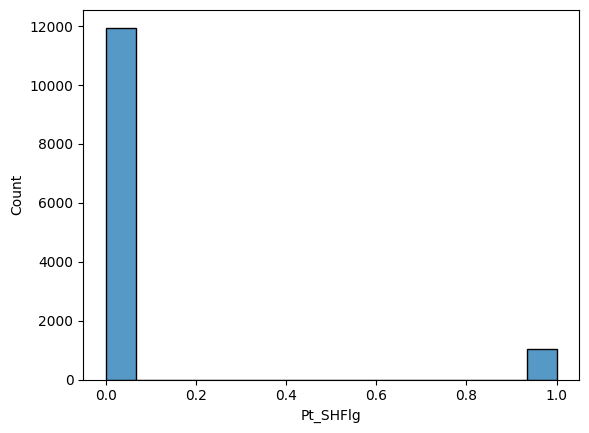

In [50]:
sns.histplot(data = y)

In [51]:
y.value_counts()

0    11949
1     1053
Name: Pt_SHFlg, dtype: int64

The dataset suffers from a serious data imbalance problem, where the minority class (1) accounts for only 8% of the total dataset. This can lead to biased model predictions and poor performance on category 1, which is the adverse events. To address this issue, we plan to use a variety of oversampling techniques, such as SMOTE, to increase the number of instances in the minority class. However, after trying SMOTE, the results were mediocre. As a next step, we plan to explore deep learning or generative learning related feature engineering approaches to further improve the performance. Additionally, we will consider using models that are insensitive to data imbalance, such as cost-sensitive learning algorithms. We will carefully evaluate the performance of each approach to determine the best way to address the data imbalance problem and improve the model's ability to correctly predict adverse events.

<Axes: xlabel='Pt_SHFlg', ylabel='HbA1c'>

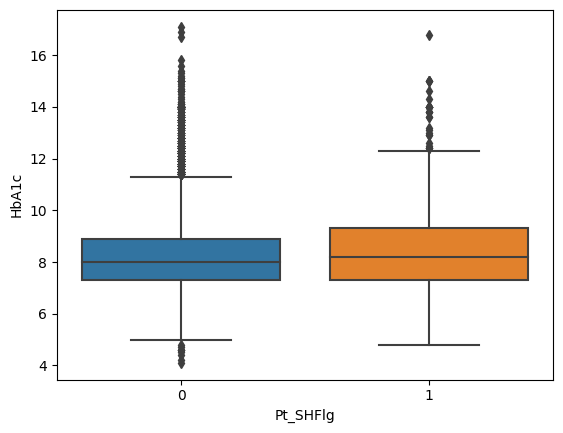

In [52]:
sns.boxplot(data = df, x = df['Pt_SHFlg'], y = df['HbA1c'])

It appears that there is a relationship between the patient's HbA1c concentration and the occurrence of adverse events. Specifically, the concentration of HbA1c was higher in users who experienced adverse events. This relationship may indicate that higher HbA1c levels increase the likelihood of adverse events occurring. 

Text(0, 0.5, 'Percentage of Patient having hypoglycemia events')

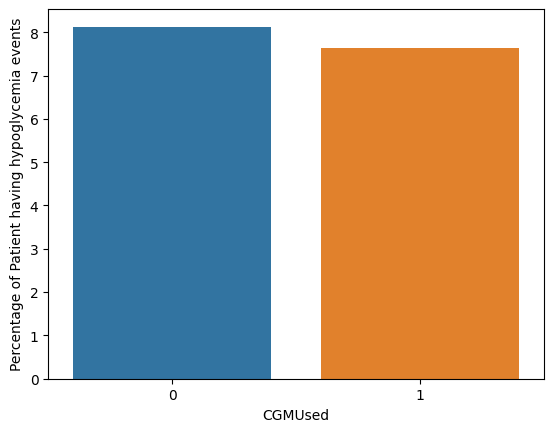

In [53]:
data_perc = df.groupby('CGMUsed')['Pt_SHFlg'].value_counts(normalize=True).mul(100).rename('percent').reset_index()
sns.barplot(x='CGMUsed', y='percent', data=data_perc[data_perc['Pt_SHFlg'] == 1])
plt.ylabel('Percentage of Patient having hypoglycemia events')

We observed a reduction in the percentage of patients experiencing hypoglycemic events among those who used CGM. This suggests that the utilization of CGM products might have a suppressive effect on the occurrence of hypoglycemic events. Further investigation is required to examine this relationship through subsequent modeling.

### Initial Model

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

sm = SMOTE(random_state=0)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

In [55]:
# param_grid = {'n_estimators': [100, 200, 300], 'max_depth': [5, 10, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
rf = RandomForestClassifier(random_state=0)
#rf_grid = GridSearchCV(rf, param_grid, cv=5)
rf.fit(X_train_res, y_train_res)
y_pred = rf.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96      2390
           1       0.00      0.00      0.00       211

    accuracy                           0.92      2601
   macro avg       0.46      0.50      0.48      2601
weighted avg       0.84      0.92      0.88      2601



It seems that the initial model was severely affected by the data imbalance, as it failed to predict the positive class events correctly. This indicates that the model was biased towards the majority class, which was expected given the severe data imbalance. To address this issue, we may consider increasing the weight of the positive class to place more importance on minimizing false negative rate, which refers to cases where the model fails to predict a positive event that actually occurs. 

Resources:
1. https://medium.com/jackys-blog/pyspark%E7%89%88-%E5%A6%82%E4%BD%95%E5%AE%8C%E6%88%90%E5%BE%9E%E9%A0%AD%E5%88%B0%E5%B0%BE%E5%AE%8C%E6%88%90%E4%B8%80%E5%80%8B%E8%B3%87%E6%96%99%E7%A7%91%E5%AD%B8%E5%B0%88%E6%A1%88-dbf0a6ec9f59
2. https://stackoverflow.com/questions/42805663/e-num-get-dummies-in-pyspark
3. https://spark.apache.org/docs/3.2.0/api/python/reference/pyspark.pandas/general_functions.html#